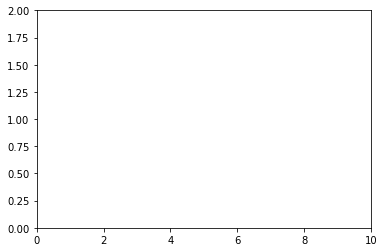

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = np.linspace(0, 10, 100)
y = 1+ np.random.randint(0,10,size=(100,1))*0.1
# print(y)

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')
line2, = ax.plot(x, y-0.1, color='k')


# print(type(line))

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 10, 0, 2])
    line2.set_data(x[:num], (y-0.1)[:num])
    line2.axes.axis([0, 10, 0, 2])
    return line,line2  # 可以同时画两个或多个线，只要在update函数中返回多个线即可


ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)
# ani.save('test.gif')
plt.show()


In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
from torch.nn import Linear, TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from util import *

# seed = 12345
# torch.manual_seed(seed)
# random.seed(seed)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_cfg):
        super(GCN, self).__init__()
        # torch.manual_seed(seed)
        self.num_cfg = num_cfg
        self.hidden_channels = hidden_channels
        self.conv1 = GCNConv(100, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        encoder_layer = TransformerEncoderLayer(hidden_channels, 2, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.lin1 = Linear(num_cfg * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch, mask, num_contracts):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = x.reshape(num_contracts, self.num_cfg, self.hidden_channels)
        # x = torch.rand(32, 10, 512)
        x = self.encoder(src=x, src_key_padding_mask=mask)
        x = x.view(num_contracts, -1)
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        
        return x

device = torch.device("cuda:1")


def train(train_loader, model, optimizer, loss_function):
    model.train()
    train_loss = 0
    # index = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        # torch.cuda.empty_cache()
        # data.to(device)
        x = data.x
        y = data.y
        edge_index = data.edge_index
        batch_index = data.batch_index
        mask = data.mask
        num_contracts = data.num_contracts
        # index += 1
        out = model(x.to(device), edge_index.to(device), batch_index.to(device), mask.to(device), num_contracts)  # Perform a single forward pass.
        loss = loss_function(out, y.to(device))  # Compute the loss.
        train_loss += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return train_loss / len(train_loader)

def test(test_loader, model):
    model.eval()

    # correct = 0
    # number = 0
    y_pred = torch.tensor([], dtype=torch.int64)
    y_true = torch.tensor([], dtype=torch.int64)
    for data in test_loader:  # Iterate in batches over the training/test dataset.
        x = data.x
        y = data.y
        edge_index = data.edge_index
        batch_index = data.batch_index
        mask = data.mask
        num_contracts = data.num_contracts
        out = model(x.to(device), edge_index.to(device), batch_index.to(device), mask.to(device), num_contracts)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        # correct += int((pred == y.to(device)).sum())  # Check against ground-truth labels.
        # number += num_contracts
        y_pred = torch.cat([y_pred, pred.cpu()])
        y_true = torch.cat([y_true, y.cpu()])
    # acc = correct / number
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return accuracy, f1

contracts = torch.load("./data/contracts1.pkl")
# random.shuffle(contracts)
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(contracts):
    train_contracts = [contracts[i] for i in train_index.tolist()]
    test_contracts = [contracts[i] for i in test_index.tolist()]
    train_loader = loadData(train_contracts, batch_size=64, shuffle=True)
    test_loader = loadData(test_contracts, batch_size=64)
    model = GCN(hidden_channels=256, num_cfg=256)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()
    criterion.to(device)
    train_losses = []
    train_acces = []
    test_acces = []
    train_f1s = []
    test_f1s = []
# loaders = loadData(contracts, batch_size=32, shuffle=True)
    for epoch in range(1, 101):
        train_loss = train(train_loader, model, optimizer, criterion)
        train_acc, train_f1 = test(train_loader, model)
        test_acc, test_f1 = test(test_loader, model)
        train_losses.append(train_loss)
        train_acces.append(train_acc)
        test_acces.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        print(f'Epoch: {epoch:03d}, Train_loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train_F1: {train_f1:.4f}, Test_F1: {test_f1:.4f}')
    x = list(range(0, 100))
    plt.plot(x, train_acces, 'b', x, test_acces, 'g')
    plt.show()
    break

Epoch: 001, Train_loss: 0.5775, Train Acc: 0.8133, Test Acc: 0.8160, Train_F1: 0.8150, Test_F1: 0.8179
Epoch: 002, Train_loss: 0.4353, Train Acc: 0.8257, Test Acc: 0.8245, Train_F1: 0.8261, Test_F1: 0.8255


KeyboardInterrupt: 